<div class="alert block-alert alert-success">
    <h1>Задания 5.1</h1>
</div>

**ABC-анализ** позволяет определить наиболее важные ресурсы компании на основе объемов продаж и прибыли.

В основе ABC-анализа лежит __«Принцип Парето»: 20% ресурсов приносят 80% прибыли__. Именно этот вид анализа позволяет выделить те самые  группы товаров, ресурсов, клиентов, поставщиков и т. п., которые и приносят компании основную прибыль.

__Задача анализа разделить товары на группы по принципу:__

- А — наиболее ценные, 20% — ассортимента (номенклатура); 80% — продаж
- В — промежуточные, 30% — ассортимента; 15% — продаж
- С — наименее ценные, 50% — ассортимента; 5% — продаж

---
## Задание 1

Сохраните все данные из таблицы `products` из PostgreSQL в дата-фрейм `products` и подготовьте данные к анализу.

1. Подгрузите данные для подключения
2. Подключите нужную библиотеку для работы с PostgreSQL
3. Создайте соединение с БД
4. Создайте запрос и выгрузите все данные из таблицы `products`
5. Положите данные в дата-фрейм `products`
6. Приведите данные к удобному типу: числа к числовому типу, идентификаторы — к текстовому


In [1]:
from postgresql_secret import pg_secret

In [2]:
import psycopg2

# создаю соединение
connection = psycopg2.connect(
                             database=pg_secret['db_name'],
                             user=pg_secret['db_user'],
                             password=pg_secret['db_password'],
                             host=pg_secret['db_host'],
                             port=pg_secret['db_port'],
                             )

# завожу курсор, чтобы делать запросы в базу
cursor = connection.cursor()

In [3]:
import pandas as pd

# переменной присваиваю запрос (если передаю одну строку, то можно использовать '')
query = """
            SELECT * 
              FROM products
        """
cursor.execute(query) # передаю запрос в метод
result = cursor.fetchall() # запрашиваю все строки

In [4]:
cursor.description # кортеж с именами и описнием колонок

(Column(name='invoice_id', type_code=23),
 Column(name='stock_code', type_code=1043),
 Column(name='description', type_code=1043),
 Column(name='quantity', type_code=23),
 Column(name='price', type_code=1700))

In [5]:
columns = []                     # в этот список сохраняю названия колонок
for desc in cursor.description:  
    columns.append(desc[0])      # названия колонок беру из первого элемента cursor.description

    
products = pd.DataFrame(result, columns=columns)  # из списка кортежей делаю датафрейм
products

,invoice_id,stock_code,description,quantity,price
0,557472,21033,JUMBO BAG CHARLIE AND LOLA TOYS,10,2.08
1,557472,20719,WOODLAND CHARLOTTE BAG,10,0.85
2,557472,22661,CHARLOTTE BAG DOLLY GIRL DESIGN,10,0.85
3,557472,84832,ZINC WILLIE WINKIE CANDLE STICK,12,0.85
4,557472,84078A,SET/4 WHITE RETRO STORAGE CUBES,4,34.95
...,...,...,...,...,...
779490,557472,85183A,CHARLIE & LOLA WASTEPAPER BIN BLUE,36,1.25
779491,557472,85183B,CHARLIE & LOLA WASTEPAPER BIN FLORA,36,1.25
779492,557472,22371,AIRLINE BAG VINTAGE TOKYO 78,4,4.25
779493,557472,22372,AIRLINE BAG VINTAGE WORLD CHAMPION,4,4.25


In [6]:
products.info() # смотрю типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   invoice_id   779495 non-null  int64 
 1   stock_code   779495 non-null  object
 2   description  779495 non-null  object
 3   quantity     779495 non-null  int64 
 4   price        779495 non-null  object
dtypes: int64(2), object(3)
memory usage: 29.7+ MB


In [7]:
# преобразовываю типы данных согласно условию

products['invoice_id'] = products['invoice_id'].apply(str)
products['price'] = products['price'].astype('float64')

In [8]:
products.info() # проверяю какие типы данных применились

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoice_id   779495 non-null  object 
 1   stock_code   779495 non-null  object 
 2   description  779495 non-null  object 
 3   quantity     779495 non-null  int64  
 4   price        779495 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 29.7+ MB


---
## Задание 2

__Посчитайте, какой доход принес каждый продукт и сколько единиц каждого продукта было продано__

1. Посчитай общую сумму оплат для каждой строки счета
2. Получи общий доход и количество единиц по товарам
3. Объедини сгруппированные данные в один датафрейм со столбцами: `description`, `stock_code`, `quantity`, `total`

In [9]:
products.sample(4) # ещё раз смотрю на таблицу

,invoice_id,stock_code,description,quantity,price
733049,551517,22554,PLASTERS IN TIN WOODLAND ANIMALS,3,1.65
584777,532964,20830,SILVER PHOTO FRAME,4,2.10
635198,538660,84029E,RED WOOLLY HOTTIE WHITE HEART.,12,3.75
484525,522089,85099F,JUMBO BAG STRAWBERRY,2,1.95


In [10]:
# считаю общую сумму оплат для каждой строки счёта

products['total_payments'] = products['quantity'] * products['price']

In [11]:
# считаю общих доход по каждому товару

total_revenue_per_product = products.groupby(products['stock_code'])['total_payments'].sum().reset_index()
total_revenue_per_product

,stock_code,total_payments
0,10002,6638.27
1,10080,124.61
2,10109,1.68
3,10120,136.08
4,10123C,226.76
...,...,...
4626,PADS,0.00
4627,POST,124648.04
4628,SP1002,14.75
4629,TEST001,225.00


In [12]:
# считаю общее количество проданных единиц по каждому товару

total_units_per_product = products.groupby(products['stock_code'])['quantity'].sum().reset_index()
total_units_per_product = total_units_per_product.rename(columns={'quantity': 'total_quantity'}) 
total_units_per_product

,stock_code,total_quantity
0,10002,8479
1,10080,303
2,10109,4
3,10120,648
4,10123C,628
...,...,...
4626,PADS,18
4627,POST,5235
4628,SP1002,5
4629,TEST001,60


In [13]:
# выделяю в отдельную таблицу товары и их описания

products_description = products[['stock_code', 'description']].drop_duplicates()
products_description

,stock_code,description
0,21033,JUMBO BAG CHARLIE AND LOLA TOYS
1,20719,WOODLAND CHARLOTTE BAG
2,22661,CHARLOTTE BAG DOLLY GIRL DESIGN
3,84832,ZINC WILLIE WINKIE CANDLE STICK
4,84078A,SET/4 WHITE RETRO STORAGE CUBES
...,...,...
758195,23086,ZINC STAR T-LIGHT HOLDER
770878,22502,PICNIC BASKET WICKER 60 PIECES
772945,23271,CHRISTMAS TABLE CANDLE SILVER SPIKE
773134,23244,CANNISTER VINTAGE LEAF DESIGN


In [14]:
""" Выясняется, что некоторым одинаковым продуктам соответствуют разные описания.
    уникальных 'stock_code' = 4631, а уникальных 'description' = 5283  """

products_description.info()
products_description.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5315 entries, 0 to 774584
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   stock_code   5315 non-null   object
 1   description  5315 non-null   object
dtypes: object(2)
memory usage: 124.6+ KB


,stock_code,description
count,5315,5315
unique,4631,5283
top,21955,WHITE BAMBOO RIBS LAMPSHADE
freq,4,3


In [15]:
# объединяю общие данные в одну таблицу

total_revenue_per_product = pd.merge(total_units_per_product,
                       total_revenue_per_product,
                       how ='inner',
                       on = 'stock_code')
    
""" Неоднозначная ситуация, не знаю что делать - в колонке 'stock_code' неуникальные значения"""
    
total_revenue_per_product = pd.merge(total_revenue_per_product, products_description,
                       how ='left',
                       on = 'stock_code')

# и меняю стобцы местами - для удобства
total_revenue_per_product = total_revenue_per_product[['stock_code','description', 'total_quantity', 'total_payments' ]]
total_revenue_per_product

,stock_code,description,total_quantity,total_payments
0,10002,INFLATABLE POLITICAL GLOBE,8479,6638.27
1,10080,GROOVY CACTUS INFLATABLE,303,124.61
2,10109,BENDY COLOUR PENCILS,4,1.68
3,10120,DOGGY RUBBER,648,136.08
4,10123C,HEARTS WRAPPING TAPE,628,226.76
...,...,...,...,...
5310,PADS,PADS TO MATCH ALL CUSHIONS,18,0.00
5311,POST,POSTAGE,5235,124648.04
5312,SP1002,KID'S CHALKBOARD/EASEL,5,14.75
5313,TEST001,This is a test product.,60,225.00


In [16]:
# проверяю данные

total_revenue_per_product.info()
total_revenue_per_product.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5315 entries, 0 to 5314
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stock_code      5315 non-null   object 
 1   description     5315 non-null   object 
 2   total_quantity  5315 non-null   int64  
 3   total_payments  5315 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 207.6+ KB


,stock_code,description,total_quantity,total_payments
count,5315,5315,5315.000000,5315.000000
unique,4631,5283,NaN,NaN
top,20685,COLOURING PENCILS BROWN TUBE,NaN,NaN
freq,4,3,NaN,NaN
mean,NaN,NaN,2554.687488,4344.022909
std,NaN,NaN,6382.474845,11522.337078
min,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,145.000000,306.575000
50%,NaN,NaN,735.000000,1157.900000
75%,NaN,NaN,2266.500000,3701.300000


In [17]:
# 2 вариант - с группировкой и аггрегацией. И, конечно, с неуникальными товарами.

total_revenue_per_product = products.groupby(['stock_code', 'description'])\
    .agg({'total_payments': 'sum',
          'quantity': 'sum'})\
    .rename(columns={'quantity': 'total_quantity'})\
    .reset_index()

total_revenue_per_product

,stock_code,description,total_payments,total_quantity
0,10002,INFLATABLE POLITICAL GLOBE,6638.27,8479
1,10080,GROOVY CACTUS INFLATABLE,124.61,303
2,10109,BENDY COLOUR PENCILS,1.68,4
3,10120,DOGGY RUBBER,136.08,648
4,10123C,HEARTS WRAPPING TAPE,226.76,628
...,...,...,...,...
5310,PADS,PADS TO MATCH ALL CUSHIONS,0.00,18
5311,POST,POSTAGE,124648.04,5235
5312,SP1002,KID'S CHALKBOARD/EASEL,14.75,5
5313,TEST001,This is a test product.,225.00,60


In [18]:
# и всё же уберу столбец  'description', тем самым считая только уникальные товары

total_revenue_per_product = products.groupby(['stock_code'])\
    .agg({'total_payments': 'sum',
          'quantity': 'sum'})\
    .rename(columns={'quantity': 'total_quantity'})\
    .reset_index()

total_revenue_per_product

,stock_code,total_payments,total_quantity
0,10002,6638.27,8479
1,10080,124.61,303
2,10109,1.68,4
3,10120,136.08,648
4,10123C,226.76,628
...,...,...,...
4626,PADS,0.00,18
4627,POST,124648.04,5235
4628,SP1002,14.75,5
4629,TEST001,225.00,60


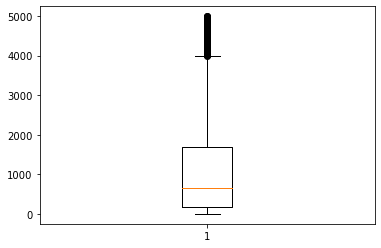

In [19]:
# смотрю, как распределены товары по общему доходу

import matplotlib.pyplot as plt

# уменьшаю разброс вручную, чтобы увидеть основное распределение
plt.boxplot(total_revenue_per_product[total_revenue_per_product['total_payments'] < 5_000]['total_payments'])
plt.show()

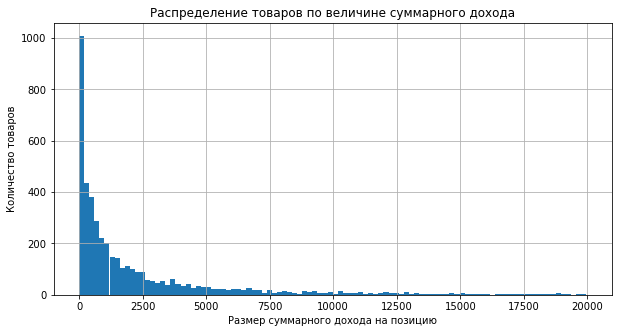

In [20]:
# строю гистограмму и смотрю распределение товаров по доходу

plt.figure(figsize=(10, 5)) # размерность
plt.title('Распределение товаров по величине суммарного дохода') 
plt.xlabel('Размер суммарного дохода на позицию') 
plt.ylabel('Количество товаров') 
plt.grid() # сетка

# уменьшаю разброс вручную, чтобы увидеть левый хвост распределения
plt.hist(total_revenue_per_product[total_revenue_per_product['total_payments'] < 20_000]['total_payments'], bins=100)

plt.show()

<div class="alert block-alert alert-warning">
Вижу, что большая часть товаров приносит доход примерно до 1800руб на позицию
</div>

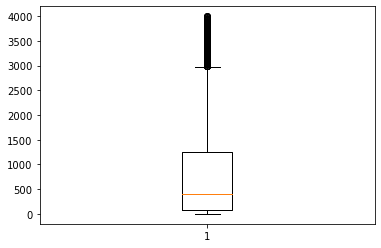

In [21]:
# смотрю, как распределены товары количеству товарных единиц

# уменьшаю разброс вручную, чтобы увидеть основное распределение
plt.boxplot(total_revenue_per_product[total_revenue_per_product['total_quantity'] < 4_000]['total_quantity'])
plt.show()

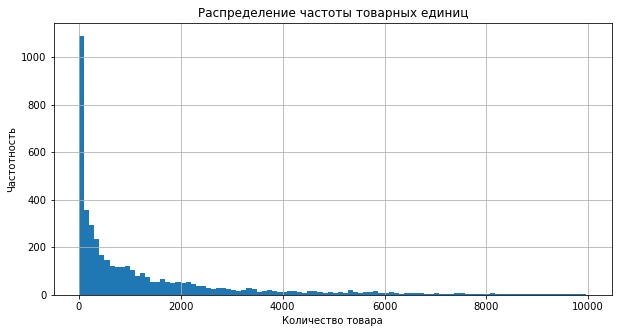

In [22]:
# строю гистограмму и смотрю распределение товаров по количеству товарных единиц

plt.figure(figsize=(10, 5)) # размерность
plt.title('Распределение частоты товарных единиц') 
plt.xlabel('Количество товара') 
plt.ylabel('Частотность') 
plt.grid() # сетка

# уменьшаю разброс вручную, чтобы увидеть левый хвост распределения
plt.hist(total_revenue_per_product[total_revenue_per_product['total_quantity'] < 10_000]['total_quantity'], bins=100)

plt.show()

<div class="alert block-alert alert-warning">
Вижу преобладание товаров в партиях до 1500шт
</div>

---
## Задание 3

__Найди нарастающий итог по процентам__

1. Отсортируй датафрейм по доходу в нисходящем порядке 
2. Найди процент дохода каждого товара в общем доходе 
3. Сделай нарастающий итог (running total) по процентам каждого товара, для этого найди в интернете и примени метод для расчета кумулятивной суммы в `pandas`. 


Нарастающий итог — это представление данных, в котором мы видим динамику нарастания или убывания суммы от начала отсчета до конца. Получаем мы эту кумулятивную сумму, прибавлением поочередно каждого следующего элемента к сумме предыдущих.  



In [23]:
# сортирую дата-фрейм по 'total_payments' в порядке убывания

total_payments_per_product = total_revenue_per_product.sort_values(by='total_payments', ascending=False)
total_payments_per_product.head(4)


,stock_code,total_payments,total_quantity
1609,22423,277656.25,24139
4080,85123A,247203.36,91814
2726,23843,168469.60,80995
4058,85099B,167920.64,93436


In [24]:
# нахожу процент дохода для каждого товара 

total_payments_sum = total_payments_per_product['total_payments'].sum() # сумма доходов от всех товаров
total_payments_per_product['revenue_percentage']\
    = total_payments_per_product['total_payments'] / total_payments_sum * 100
total_payments_per_product.head(4)

,stock_code,total_payments,total_quantity,revenue_percentage
1609,22423,277656.25,24139,1.598040
4080,85123A,247203.36,91814,1.422769
2726,23843,168469.60,80995,0.969620
4058,85099B,167920.64,93436,0.966461


In [25]:
# считаю кумулятивную сумму процента дохода для каждого товара ('revenue_percentage')

total_payments_per_product['cumulative_sum_revenue'] = total_payments_per_product['revenue_percentage'].cumsum()
total_payments_per_product.tail()

,stock_code,total_payments,total_quantity,revenue_percentage,cumulative_sum_revenue
4630,TEST002,1.00,1,0.000006,99.999991
247,20721,0.85,1,0.000005,99.999996
3419,84205C,0.38,2,0.000002,99.999998
2847,35930,0.38,1,0.000002,100.000000
4626,PADS,0.00,18,0.000000,100.000000


<div class="alert block-alert alert-warning">
<b>Проверка суммы доходов всех товаров:</b><br>
    - суммы дохода по всем товарам, подсчитанные на начальных данных и взятых из текущей таблицы равны и составляют 17374804.25<br>
    - кумулятивная сумма по нарастающим процентам в конце списка равна 100%
</div>

In [26]:
(products['quantity'] * products['price']).sum() # беру изначальные данные - количество товара и их цену

17374804.250000004

In [27]:
total_payments_per_product['total_payments'].sum() # данные из рабочей таблицы, по которой считаю кумулятивную сумму

17374804.250000007

---
## Задание 4

__Пометь товары метками `'A'`, `'B'`, `'C'` в зависимости от нарастающего итога__

1. Напиши функцию, которая будет помечать товары с нарастающим итогом ниже или равно 80% как группу `'A'`, от 80%-95% — как `'B'` и остальные как `'C'`

In [28]:
# total_payments_per_product.drop(columns=['revenue'])

In [29]:
# функция маркирует значения по порогу

def threshold_marking(x):
    if x <= 80:
        return 'A'
    elif x <= 95:
        return 'B'
    else:
        return 'C'

In [30]:
# создаю новый столбец с маркерами

total_payments_per_product['revenue'] = total_payments_per_product['cumulative_sum_revenue'].apply(threshold_marking)

In [31]:
total_payments_per_product.sample(5)

,stock_code,total_payments,total_quantity,revenue_percentage,cumulative_sum_revenue,revenue
2930,37479B,1011.48,1240,0.005822,95.437641,C
893,21558,9236.10,3880,0.053158,61.622573,A
479,21056,4681.63,525,0.026945,76.254820,A
2708,23579,276.15,149,0.001589,99.314119,C
290,20775,749.85,3509,0.004316,96.942855,C


---
## Задание 5

__Найди нарастающий итог по количеству товарных единиц и пометь товары метками `'A'`, `'B'`, `'C'`, отмечая тем самым популярность товара__

1. Отсортируй предыдущий датафрейм с данными о доходе теперь по количеству товаров
2. Найди процент каждого товара в общем количестве
3. Найди нарастающий итог по количеству
4. Напиши функцию с теми же параметрами, что и у дохода
5. Отметь группу

In [32]:
# сортирую дата-фрейм по количеству товаров ('total_quantity') в порядке убывания

total_quantity_per_product = total_revenue_per_product.sort_values(by='total_quantity', ascending=False)
total_quantity_per_product.head(4)

,stock_code,total_payments,total_quantity
3410,84077,24098.03,105185
4058,85099B,167920.64,93436
4080,85123A,247203.36,91814
601,21212,43390.03,89850


In [33]:
# нахожу процент количества товаров для каждого товара 

total_quantity_sum = total_quantity_per_product['total_quantity'].sum()
total_quantity_per_product['quantity_percentage'] = total_quantity_per_product['total_quantity'] / total_quantity_sum * 100
total_quantity_per_product.head(4)

,stock_code,total_payments,total_quantity,quantity_percentage
3410,84077,24098.03,105185,0.999031
4058,85099B,167920.64,93436,0.887441
4080,85123A,247203.36,91814,0.872035
601,21212,43390.03,89850,0.853381


In [34]:
# считаю кумулятивную сумму количества товаров  для каждого товара ('quantity_percentage')

total_quantity_per_product['cumulative_sum_quantity'] = total_quantity_per_product['quantity_percentage'].cumsum()
total_quantity_per_product.head(4)

,stock_code,total_payments,total_quantity,quantity_percentage,cumulative_sum_quantity
3410,84077,24098.03,105185,0.999031,0.999031
4058,85099B,167920.64,93436,0.887441,1.886471
4080,85123A,247203.36,91814,0.872035,2.758506
601,21212,43390.03,89850,0.853381,3.611888


In [35]:
# создаю новый столбец с маркерами
 
total_quantity_per_product['popularity'] = total_quantity_per_product['cumulative_sum_quantity'].apply(threshold_marking)

In [36]:
total_quantity_per_product.sample(5)

,stock_code,total_payments,total_quantity,quantity_percentage,cumulative_sum_quantity,popularity
439,20993,1305.49,10945,0.103954,41.822332,A
1887,22713,2214.28,5625,0.053425,60.363539,A
1774,22598,881.72,1562,0.014836,87.504437,B
4293,90029,178.50,21,0.000199,99.959786,C
3391,82616C,791.22,539,0.005119,96.692499,C


---
## Задание 6

__Объедини группы и проанализируй__

1. Создай серию `group` с объединенным столбцом отметок популярности и доходности товаров
2. Посчитай количество вхождений каждой сгруппированной пары
3. Какие группы непопулярны и приносят мало дохода?
4. На каких группах товаров нужно сфокусироваться при составлении плана закупок?

In [37]:
# объединяю таблицы и создаю столбец совмещённых отметок популярности и доходности товаров

group_per_product = pd.merge(total_payments_per_product[['stock_code', 'revenue']], total_quantity_per_product[['stock_code', 'popularity']],
              on = 'stock_code',
              how = 'inner')
group_per_product_series = group_per_product['revenue'] + group_per_product['popularity']

In [38]:
# считаю количество вхождений каждой сгрупированной пары

group_per_product_series.value_counts()

CC    2041
AA     685
BB     577
BC     377
CB     303
BA     270
AB     248
CA      72
AC      58
dtype: int64

<div class="alert block-alert alert-warning">
Оутсайдеры -<br>
    - товары AC: с доходностью <= 80% и популярностью > 95%<br>
    - товары СА: с доходностью > 95% и популярностью < 80%<br><br>
Лидеры - <br>
    - товары СC: с доходностью > 95% и популярностью > 95%<br><br>
Остальные середнячки
</div>

In [39]:
# завожу словарь с расшифровкой маркеров

revenue_dict = {"A": "с низкой доходностью", 'B': "со средней доходностью", 'C': "с высокой доходностью",}
popularity_dict = {'A': "разовые",'B': "редкие", 'C': "частые",}

In [40]:
# опять считаю количество вхождений каждой пары, но получаю dataframe

group_per_product = group_per_product.groupby(['revenue', 'popularity'],  as_index=False)['stock_code'].count()

In [41]:
# заменяю условные обозначения на словарные

group_per_product['revenue'] = group_per_product['revenue'].map(revenue_dict)
group_per_product['popularity'] = group_per_product['popularity'].map(popularity_dict)

In [42]:
# собираю сводную таблицу

pivot_product = group_per_product.pivot(index = 'revenue', 
                columns = 'popularity', 
                values = "stock_code").reset_index()

# pivot_product.fillna(0, inplace=True)
pivot_product = pivot_product.set_index('revenue').sort_values(['частые'], ascending = False)
pivot_product

popularity,разовые,редкие,частые
revenue,,,
с высокой доходностью,72,303,2041
со средней доходностью,270,577,377
с низкой доходностью,685,248,58


In [43]:
import seaborn as sns

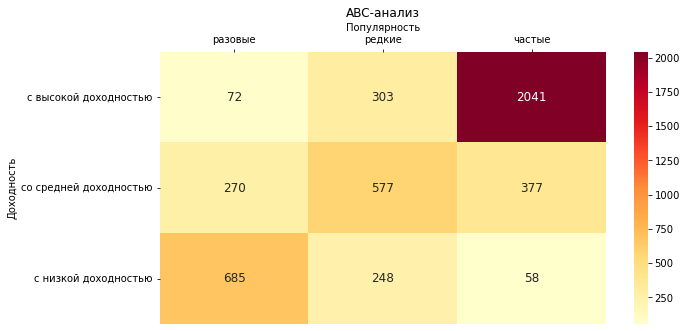

In [44]:
# строю тепловую карту, наглядно подтверждаю предыдущие выводы о распределении товаров

f, ax = plt.subplots(figsize=(10, 5)) # создаю фигуру и оси
                     
sns.heatmap(pivot_product, 
            annot=True,
            cmap="YlOrRd",
            fmt='g',
            annot_kws={'size':12}) # вручную задаю размер шрифта в ячейках
            
plt.title("ABC-анализ")            
plt.yticks(rotation=0) # вручную задаю угол подписей
ax.xaxis.set_ticks_position('top') # указываю, что метки оси x должны быть наверху
ax.xaxis.set_label_position('top') # указываю, что подпись оси x должна быть наверху
            

plt.ylabel("Доходность")
plt.xlabel("Популярность")
plt.show()

<div class="alert block-alert alert-warning">
    <b>Выводы:</b><br><br>
В общем у нас хорошая картина складывается по товарам с высокой доходностью - их много и они попуряны. Остаётся поддерживать на этом уровне.<br><br>
По разовым товарам тоже хорошо, пусть их приобретают редко - погоды не сделает. Главное на них не тратить ресурсы. По популярности зависимость тоже хорошая - количество уменьшается с увеличением частоты.<br><br>
По товарам средней доходности - хорошо бы сместить частотность вправо, сделать более попурярными. Но и сейчас не плохо.
</div>

---
## Задание 7

__Выгрузи данные по товарам с меткой по ABC-анализу__

1. Объедини по `stock_code` в одной таблице `ABC-код`, описание товара и `ID `

2. Выгрузи таблицу в `csv` для отправки в отдел закупок

In [45]:
total_table = pd.merge(total_payments_per_product[['stock_code', 'revenue']], total_quantity_per_product[['stock_code', 'popularity']],
              on = 'stock_code',
              how = 'inner')

In [46]:
total_table['revenue_popularity'] = total_table['revenue'] + total_table['popularity']

In [47]:
""" Вспоминаю, что у меня есть таблица с описаниями товаров и объединяю её с предыдущей,
    но также помню, что появляются неуникальные позиции товаров в таблице """

total_table = pd.merge(total_table[['stock_code', 'revenue_popularity']], products_description,
              on = 'stock_code',
              how = 'inner').set_index('stock_code')
total_table.sample(5)

,revenue_popularity,description
stock_code,,
90214K,CC,"LETTER ""K"" BLING KEY RING"
90200C,CC,BLUE SWEETHEART BRACELET
17014A,CC,ORIGAMI VANILLA INCENSE CONES
22087,AA,PAPER BUNTING WHITE LACE
90014A,CC,SILVER/MOP ORBIT NECKLACE


In [48]:
# выгружаю в файл

total_table.to_csv('ABC_products.csv')